In [25]:
import pandas as pd
import pandas as pd
from pathlib import Path
from utils.distfit import *
from utils.clustering import *
from utils.scenario_gen import *
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

In [26]:
datapath = Path(Path().cwd().parents[3]) / 'DR_IJMUIDEN' / 'data'
savepath = datapath / 'forecast data' / 'Scenarios'
distpath = datapath / 'forecast data' / 'Distributions'
tpepath = datapath / 'forecast data' / 'TPE Search results'

waterboards = ['HHNK', 'HDSR', 'Rijnland', 'Waternet']

In [27]:
def get_tpepath(name):
    if name in waterboards:
        return tpepath / 'CQRDNN_Waterboards' / name / 'Forecasts'
    elif name == 'WL':
        return tpepath / 'CQRDNN_WL_IJmuiden' / 'Forecasts'
    elif name == 'DAM':
        return tpepath / 'CQRDNN_DAM' / 'Forecasts'
    else:
        raise ValueError(f'Invalid name: {name}')

In [28]:
def get_distpath(name):
    if name in waterboards:
        return distpath / f'{name}.pkl'
    elif name == 'WL':
        return distpath / f'WL.pkl'
    elif name == 'DAM':
        return distpath / f'DAM.pkl'
    else:
        raise ValueError(f'Invalid name: {name}')

In [29]:
def get_data(name):
    path = get_tpepath(name)
    if name == 'DAM':
        val_data = pd.concat([pd.read_pickle(path / 'y_train.pkl'), pd.read_pickle(path / 'y_val.pkl')], axis=0).astype(float).sort_index()
        val_data = val_data.loc[:, [col for col in val_data.columns if ('q0.5' in col) and ('NL' in col)]]
        val_data.columns = [f'DAM NL +{h}' for h in range(1,49)]
        distribution_df_ = pd.read_pickle(get_distpath(name))
        # distribution_df_ = pd.read_csv(get_distpath(name), index_col=[0,1], parse_dates=True, header=[0,1])
        distribution_df_.index = distribution_df_.index.droplevel(1)
        indices = np.array([i for i in range(0, len(distribution_df_.index), 2)])
        distribution_df = pd.concat([distribution_df_.iloc[indices, :], distribution_df_.iloc[indices+1, :]], axis=1)
        distribution_df.columns = pd.MultiIndex.from_product([[f'DAM NL_{i}' for i in range(1,49)], ['dist', 'params', 'KS']])
    
    else:
        if name in waterboards + ['WL']:
            f = 'y_train.csv'
        else:
            f = 'y_trainval.csv'
        val_data = pd.read_csv(path / f, index_col=0, parse_dates=True).astype(float)
        if name in waterboards:
            val_data = val_data.loc[:, [f'Aggregated +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'Q +{i}' for i in range(1, 49)]
            
        elif name == 'WL':
            val_data = val_data.loc[:, [f'WL +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'WL +{i}' for i in range(1, 49)]
        distribution_df = pd.read_pickle(get_distpath(name))
        #distribution_df = pd.read_csv(get_distpath(name), index_col=0, parse_dates=True, header=[0,1])
    return val_data, distribution_df

In [30]:
hydrological_year = 2019
market_year = 2020

In [31]:
class ScenarioGenerator():
    def __init__(self, name, varname, valmin=None, valmax=None, scenario_mask=None):
        self.name = name
        self.varname = varname
        self.val_data, self.distribution_df = get_data(name)
        self.indices = self.distribution_df.index

        
        if self.name in ['Rijnland', 'Waternet', 'HDSR', 'HHNK']:
            self.scenario_mask = (0, self.val_data.max().max())
        elif self.name == 'WL':
            self.scenario_mask = (self.val_data.min().min(), self.val_data.max().max())
        else:
            self.scenario_mask = scenario_mask


        if valmin is None:
            self.valmin = np.floor(self.val_data.min().min() * 10) / 10 / 10
            self.valmax = np.ceil(self.val_data.max().max() * 10) / 10 * 10
        else:
            self.valmin = valmin
            self.valmax = valmax

        self.distributionloader = DistributionLoader(self.distribution_df, self.varname, valmin=self.valmin, valmax=self.valmax)
        self.make_bn()
    
    def make_bn(self):
        self.bn = BN(self.val_data, self.distributionloader, varname=self.varname, n=len(self.val_data.columns), threshold=None)
        self.bn.make_structure()

    def sample_scenarios(self, date, n=1000, BN=True, return_df=True):
        if BN:
            self.scenarios = self.bn.sample_BN(date, n).round(2)
        else:
            self.scenarios = pd.DataFrame(index=range(n), columns=self.val_data.columns)
            for col in self.val_data.columns:
                dist = self.distribution_df.loc[date, (col, 'dist')]
                params = self.distribution_df.loc[date, (col, 'params')]
                self.scenarios.loc[:, col] = get_rv(dist, params).rvs(n)

        if self.scenario_mask is not None:
            self.scenarios[self.scenarios < self.scenario_mask[0]] = self.scenario_mask[0]
            self.scenarios[self.scenarios > self.scenario_mask[1]] = self.scenario_mask[1]

        if return_df:
            return self.scenarios

    def cluster_scenarios(self, subset_size, method='energy', return_df=True):
        energy_clusterer = ReduceForward(x=self.scenarios.values, cdn=subset_size, dist=method, verbose=False)
        energy_clusterer.reduce_forward()
        self.clusters = energy_clusterer.clusters
        self.clusters.columns=[col for col in self.scenarios.columns] + ['weights']
        if return_df:
            return self.clusters

In [32]:
class DischargeGenerator():
    def __init__(self, scenario_generator_dict):
        self.waterboards = ['HHNK', 'Rijnland', 'Waternet', 'HDSR']
        self.scenario_generator_dict = scenario_generator_dict

    def sample_scenarios(self, date, n=1000, BN=True, return_df=True):
        self.wb_scenarios = {}
        for wb in self.waterboards:
            self.wb_scenarios[wb] = self.scenario_generator_dict[wb].sample_scenarios(date, n=n, return_df=True)
        
        if return_df:
            return self.wb_scenarios
    
    def cluster_wb_scenarios(self, subset_size, method='energy', return_df=True):
        # Cluster the individual waterboard scenarios
        ind = pd.MultiIndex.from_product([range(subset_size), self.waterboards], names=['cluster', 'waterboard'])
        cluster_cols = [col for col in self.wb_scenarios[self.waterboards[0]].columns] + ['weights']
        self.wb_clusters = pd.DataFrame(index=ind, columns=cluster_cols, dtype=float)
        self.idx = pd.IndexSlice
        for wb in self.waterboards:
            self.wb_clusters.loc[self.idx[:, wb], :] = self.scenario_generator_dict[wb].cluster_scenarios(subset_size, method=method, return_df=True).values
        
        if return_df:
            return self.wb_clusters
    
    def _sum_discharges(self, comb):
        return np.sum( np.array([
            self.wb_clusters.loc[self.idx[comb[i], wb], [col for col in self.wb_clusters.columns if col != 'weights']].values 
            for i, wb in enumerate(self.waterboards) ]), axis=0)

    def combine_clusters(self, subset_size, return_df=True):
        combinations = list(itertools.product(*[range(len(self.wb_clusters.loc[self.idx[:, wb], :].index)) for wb in self.waterboards]))
        # res = Parallel(n_jobs=-1, verbose=1)(delayed(self._sum_discharges)(comb) for comb in combinations)
        # self.combined_scenarios = pd.DataFrame(res, columns=[col for col in self.wb_clusters.columns if col != 'weights'])
        self.combined_scenarios = pd.DataFrame(index=range(len(combinations)), columns=[col for col in self.wb_clusters.columns if col != 'weights'], dtype=float)
        for i, comb in enumerate(combinations):
            self.combined_scenarios.loc[i, :] = self._sum_discharges(comb)

        clusterer = ReduceForward(x=self.combined_scenarios.values, cdn=subset_size, dist='energy', verbose=False)
        clusterer.reduce_forward()
        self.combined_clusters = clusterer.clusters
        self.combined_clusters.columns=[col for col in self.combined_scenarios.columns] + ['weights']
        if return_df:
            return self.combined_clusters

In [33]:
dam_gen = ScenarioGenerator('DAM', 'DAM NL')
HHNK_gen = ScenarioGenerator('HHNK', 'Aggregated')
HDSR_gen = ScenarioGenerator('HDSR', 'Aggregated')
Rijnland_gen = ScenarioGenerator('Rijnland', 'Aggregated')
Waternet_gen = ScenarioGenerator('Waternet', 'Aggregated')
WL_gen = ScenarioGenerator('WL', 'WL')

In [47]:
WL_gen = ScenarioGenerator('WL', 'WL')

In [34]:
discharge_gen = DischargeGenerator({'HHNK': HHNK_gen, 'HDSR': HDSR_gen, 'Rijnland': Rijnland_gen, 'Waternet': Waternet_gen})

In [35]:
HHNK_gen.distribution_df.index[200]

(Timestamp('2019-01-01 04:00:00+0000', tz='UTC'),
 Timestamp('2019-01-01 13:00:00+0000', tz='UTC'))

In [36]:
HHNK_gen.distribution_df

dist  \
forecast_time             observation_time                         
2019-01-01 00:00:00+00:00 2019-01-01 01:00:00+00:00     logistic   
                          2019-01-01 02:00:00+00:00     logistic   
                          2019-01-01 03:00:00+00:00  weibull_min   
                          2019-01-01 04:00:00+00:00    lognormal   
                          2019-01-01 05:00:00+00:00     rayleigh   
...                                                          ...   
2021-01-30 19:00:00+00:00 2021-02-01 15:00:00+00:00     rayleigh   
                          2021-02-01 16:00:00+00:00     rayleigh   
                          2021-02-01 17:00:00+00:00  weibull_min   
                          2021-02-01 18:00:00+00:00     rayleigh   
                          2021-02-01 19:00:00+00:00  weibull_min   

                                                                                     params  \
forecast_time             observation_time                                                    
2019-01-01 00:00:00+00:00 2019-01-01 01:00:00+00:00               [19.01925197, 2.94611983]   
                          2019-01-01 02:00:00+00:00               [17.50013167, 3.82426944]   
                          2019-01-01 03:00:00+00:00  [3.61866696, -7.71937152, 25.89581075]   
                          2019-01-01 04:00:00+00:00  [0.1432024, -40.27764663, 53.66757148]   
                          2019-01-01 05:00:00+00:00              [-2.43379869, 11.69501496]   
...                                                                                     ...   
2021-01-30 19:00:00+00:00 2021-02-01 15:00:00+00:00              [-4.10602727, 16.52437087]   
                          2021-02-01 16:00:00+00:00              [-4.23110446, 16.49785827]   
                          2021-02-01 17:00:00+00:00  [1.84984948, -3.32192573, 22.11970837]   
                          2021-02-01 18:00:00+00:00                 [-4.13048, 15.99608097]   
                          2021-02-01 19:00:00+00:00   [1.64777418, -2.55678719, 20.8824001]   

                                                           KS  
forecast_time             observation_time                     
2019-01-01 00:00:00+00:00 2019-01-01 01:00:00+00:00  0.013068  
                          2019-01-01 02:00:00+00:00  0.009153  
                          2019-01-01 03:00:00+00:00   0.00757  
                          2019-01-01 04:00:00+00:00  0.013305  
                          2019-01-01 05:00:00+00:00  0.016492  
...                                                       ...  
2021-01-30 19:00:00+00:00 2021-02-01 15:00:00+00:00  0.021567  
                          2021-02-01 16:00:00+00:00  0.023923  
                          2021-02-01 17:00:00+00:00  0.022993  
                          2021-02-01 18:00:00+00:00  0.024557  
                          2021-02-01 19:00:00+00:00  0.024807  

[876480 rows x 3 columns]

In [13]:
date = HHNK_gen.distribution_df.index.droplevel(1).unique()[200]
gen = discharge_gen
gen.sample_scenarios(date, n=1000, BN=True, return_df=False)

In [37]:
n_seperate_wb_scenarios = 5
n_combined_wb_scenarios = 5
n_dam_scenarios = 5
n_wl_scenarios = 5

In [15]:
gen.cluster_wb_scenarios(n_seperate_wb_scenarios, method='energy', return_df=True)

Aggregated1  Aggregated2  Aggregated3  Aggregated4  \
cluster waterboard                                                       
0       HHNK               0.63         5.34         1.47         4.97   
        Rijnland           1.68         4.33         3.69         4.54   
        Waternet           2.91         2.94         5.25         5.45   
        HDSR               5.99         5.45         6.90         9.06   
1       HHNK               1.83        12.15         0.88         1.26   
        Rijnland           0.90         0.34         0.00         0.00   
        Waternet           0.80         0.24         0.40         1.65   
        HDSR               6.74         6.68         5.89         5.50   
2       HHNK               0.00         0.00         0.16        -0.00   
        Rijnland           0.44         1.16         3.76         6.46   
        Waternet           1.58         1.56         1.02         1.11   
        HDSR              10.85         9.38         9.58         8.52   
3       HHNK               0.00         0.00         1.65         1.14   
        Rijnland           0.54         1.36         2.32         3.93   
        Waternet           2.76         2.57         1.79         3.09   
        HDSR              10.18        11.88        12.51        11.38   
4       HHNK               0.80         7.36         2.34         8.31   
        Rijnland           0.84         1.50         1.34         0.50   
        Waternet           1.75         0.64         0.89         2.45   
        HDSR               4.25         5.48         4.65         4.19   

                    Aggregated5  Aggregated6  Aggregated7  Aggregated8  \
cluster waterboard                                                       
0       HHNK               3.57         8.42        12.91         8.93   
        Rijnland           3.41         7.07         5.99        14.13   
        Waternet           8.53         8.42         8.17         8.06   
        HDSR               7.53         6.43         6.81         7.92   
1       HHNK               1.18         3.85         5.05         3.74   
        Rijnland           0.10         0.19         0.80         0.25   
        Waternet           2.30         3.93         5.61         3.98   
        HDSR               4.75         6.36         6.61         7.48   
2       HHNK               0.19         0.13         0.19         1.95   
        Rijnland          21.15        17.95         7.80        24.96   
        Waternet           2.48         3.17         4.69         4.75   
        HDSR               8.95         8.40         9.07         8.16   
3       HHNK               1.07         0.59         0.34         1.27   
        Rijnland           6.64         2.08         2.98         5.42   
        Waternet           5.93         6.88         7.63         7.67   
        HDSR              10.90         9.27        11.28        11.52   
4       HHNK              15.34         8.52         4.60         3.78   
        Rijnland           0.20         0.29         0.99         1.44   
        Waternet           2.71         3.63         4.94         3.42   
        HDSR               3.99         4.42         4.83         5.81   

                    Aggregated9  Aggregated10  ...  Aggregated40  \
cluster waterboard                             ...                 
0       HHNK              22.91         20.73  ...     23.670000   
        Rijnland           6.73          3.23  ...     70.383333   
        Waternet           6.32          4.09  ...     11.150000   
        HDSR               7.89          6.55  ...      8.080000   
1       HHNK               0.75          1.61  ...      4.360000   
        Rijnland           1.65          0.10  ...      1.510000   
        Waternet           1.72          1.07  ...      7.000000   
        HDSR               8.04          8.27  ...      8.580000   
2       HHNK               3.08          4.27  ...      0.000000   
        Rijnla

In [16]:
gen.combine_clusters(n_combined_wb_scenarios)

,Aggregated1,Aggregated2,Aggregated3,Aggregated4,Aggregated5,Aggregated6,Aggregated7,Aggregated8,Aggregated9,Aggregated10,...,Aggregated40,Aggregated41,Aggregated42,Aggregated43,Aggregated44,Aggregated45,Aggregated46,Aggregated47,Aggregated48,weights
0,6.12,12.22,10.28,17.27,31.01,34.72,31.15,43.68,36.4,35.82,...,43.6,39.74,52.66,43.38,49.21,52.85,27.89,21.94,14.35,0.223143
1,14.13,26.95,16.73,17.68,21.2,18.37,24.0,25.43,17.27,18.01,...,29.54,33.01,46.3,46.65,46.68,46.12,40.6,35.97,24.17,0.196760
2,9.65,8.36,8.85,12.15,13.75,13.63,15.43,17.79,17.33,12.94,...,20.34,20.39,32.83,32.2,34.25,22.01,24.19,21.09,13.02,0.188620
3,9.59,9.52,10.19,12.65,13.85,13.73,15.62,18.98,18.45,14.79,...,28.12,20.25,24.52,29.28,36.2,34.13,31.38,32.25,56.99,0.196517
4,10.58,12.72,17.49,20.19,20.54,22.51,21.31,31.38,21.38,13.99,...,93.643333,98.183333,98.553333,57.24,98.19,80.11,72.81,57.43,46.41,0.194960


<Axes: >

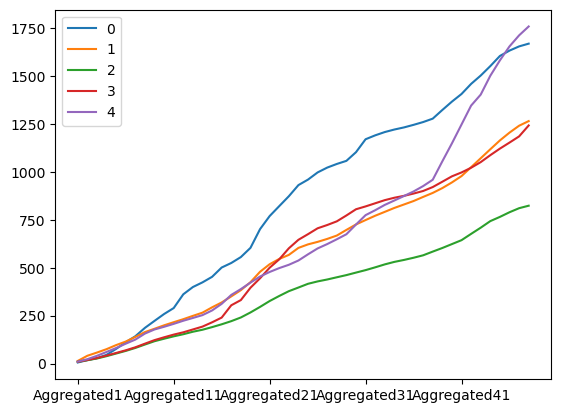

In [17]:
gen.combined_clusters.iloc[:, :-1].T.cumsum().plot()

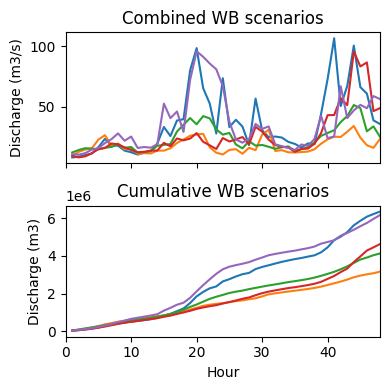

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
# gen.combined_clusters.iloc[:, :-1].T.plot(ax=ax[0])
ax[0].plot(range(1, 49), gen.combined_clusters.iloc[:, :-1].T)
ax[0].set_title('Combined WB scenarios')
# ax[0].set_xlabel('Hour')
ax[0].set_xlim(0, 48)
ax[0].set_ylabel('Discharge (m3/s)')

ax[1].plot(range(1,49), gen.combined_clusters.iloc[:, :-1].T.cumsum()*3600)
ax[1].set_title('Cumulative WB scenarios')
ax[1].set_xlabel('Hour')
ax[1].set_xlim(0, 48)
ax[1].set_ylabel('Discharge (m3)')

fig.tight_layout()


In [38]:
hydrological_indices = HHNK_gen.distribution_df.index.droplevel(1).unique()
hydrological_indices

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-01 01:00:00+00:00',
               '2019-01-01 02:00:00+00:00', '2019-01-01 03:00:00+00:00',
               '2019-01-01 04:00:00+00:00', '2019-01-01 05:00:00+00:00',
               '2019-01-01 06:00:00+00:00', '2019-01-01 07:00:00+00:00',
               '2019-01-01 08:00:00+00:00', '2019-01-01 09:00:00+00:00',
               ...
               '2021-01-30 10:00:00+00:00', '2021-01-30 11:00:00+00:00',
               '2021-01-30 12:00:00+00:00', '2021-01-30 13:00:00+00:00',
               '2021-01-30 14:00:00+00:00', '2021-01-30 15:00:00+00:00',
               '2021-01-30 16:00:00+00:00', '2021-01-30 17:00:00+00:00',
               '2021-01-30 18:00:00+00:00', '2021-01-30 19:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='forecast_time', length=18260, freq=None)

In [22]:
n_discharge_scenarios_sep = 5
n_discharge_scenarios_comb = 5

idx = pd.IndexSlice
discharge_scenarios = pd.DataFrame(index=pd.MultiIndex.from_product([hydrological_indices, range(n_discharge_scenarios_comb)], names=['date', 'scenario']), columns=gen.combined_clusters.columns, dtype=float)
for date in tqdm(hydrological_indices):
    discharge_gen.sample_scenarios(date, n=1000, BN=True, return_df=False)
    discharge_gen.cluster_wb_scenarios(n_discharge_scenarios_sep, method='energy', return_df=False)
    discharge_gen.combine_clusters(n_discharge_scenarios_comb, return_df=False)
    discharge_scenarios.loc[idx[date, :], :] = discharge_gen.combined_clusters.values

discharge_scenarios.to_csv(savepath / f'discharge_scenarios_{n_discharge_scenarios_sep}_{n_discharge_scenarios_comb}.csv')

  0%|          | 0/744 [00:00<?, ?it/s]d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 744/744 [4:13:11<00:00, 20.42s/it]  


In [39]:
wl_indices = WL_gen.distribution_df.index.droplevel(1).unique()
wl_indices

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-01 01:00:00+00:00',
               '2019-01-01 02:00:00+00:00', '2019-01-01 03:00:00+00:00',
               '2019-01-01 04:00:00+00:00', '2019-01-01 05:00:00+00:00',
               '2019-01-01 06:00:00+00:00', '2019-01-01 07:00:00+00:00',
               '2019-01-01 08:00:00+00:00', '2019-01-01 09:00:00+00:00',
               ...
               '2021-01-30 10:00:00+00:00', '2021-01-30 11:00:00+00:00',
               '2021-01-30 12:00:00+00:00', '2021-01-30 13:00:00+00:00',
               '2021-01-30 14:00:00+00:00', '2021-01-30 15:00:00+00:00',
               '2021-01-30 16:00:00+00:00', '2021-01-30 17:00:00+00:00',
               '2021-01-30 18:00:00+00:00', '2021-01-30 19:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='forecast_time', length=18260, freq=None)

In [43]:
def parallel_scenario_clustering(generator, date):
    generator.name='a'
    

In [44]:
WL_gen.name

'WL'

In [46]:
parallel_scenario_clustering(WL_gen, wl_indices[0])
WL_gen.name

'a'

In [23]:
n_wl_scenarios = 5
idx = pd.IndexSlice
cols = [col for col in WL_gen.val_data.columns] + ['weights']
wl_scenarios = pd.DataFrame(index=pd.MultiIndex.from_product([hydrological_indices, range(n_wl_scenarios)], names=['date', 'scenario']), columns=cols, dtype=float)
for date in tqdm(hydrological_indices):
    WL_gen.sample_scenarios(date, n=1000, BN=True, return_df=False)
    WL_gen.cluster_scenarios(n_wl_scenarios, method='energy', return_df=False)
    wl_scenarios.loc[idx[date, :], :] = WL_gen.clusters.values

wl_scenarios.to_csv(savepath / f'wl_scenarios_{n_wl_scenarios}.csv')
    

 23%|██▎       | 168/744 [12:30<42:51,  4.46s/it]


KeyError: Timestamp('2019-01-08 00:00:00+0000', tz='UTC')

In [ ]:
market_indices = dam_gen.distribution_df.index.droplevel(1).unique()
market_indices

Index([2021-01-12 00:00:00+01:00, 2021-01-13 00:00:00+01:00,
       2021-01-14 00:00:00+01:00, 2021-01-15 00:00:00+01:00,
       2021-01-18 00:00:00+01:00, 2021-01-19 00:00:00+01:00,
       2021-01-20 00:00:00+01:00, 2021-01-21 00:00:00+01:00],
      dtype='object')

In [ ]:
n_dam_scenarios = 5
idx = pd.IndexSlice
cols = [col for col in dam_gen.val_data.columns] + ['weights']
dam_scenarios = pd.DataFrame(index=pd.MultiIndex.from_product([market_indices, range(n_dam_scenarios)], names=['date', 'scenario']), columns=cols, dtype=float)
for date in tqdm(market_indices):
    dam_gen.sample_scenarios(date, n=1000, BN=True, return_df=False)
    dam_gen.cluster_scenarios(n_dam_scenarios, method='energy', return_df=False)
    dam_scenarios.loc[idx[date, :], :] = dam_gen.clusters.values

dam_scenarios.to_csv(savepath / f'dam_scenarios_{n_dam_scenarios}.csv')

100%|██████████| 8/8 [00:52<00:00,  6.57s/it]


<AxesSubplot: >

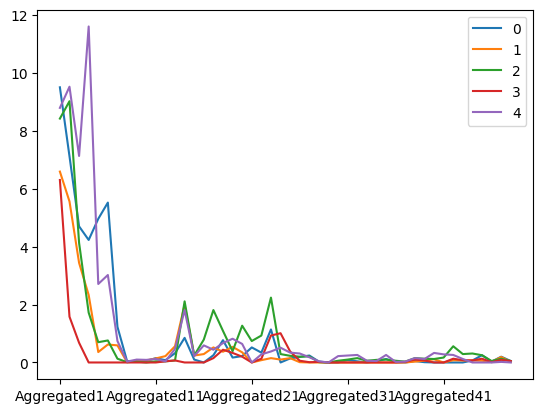

In [18]:
gen.cluster_scenarios(5, method='energy').iloc[:,:-1].T.plot(
    # Legend labels are the weights in the last column
    # So plot the scenarios with the weights as label
    label=gen.clusters.iloc[:,-1].values,
)

In [17]:
gen.clusters.iloc[:,:-1]

,Aggregated1,Aggregated2,Aggregated3,Aggregated4,Aggregated5,Aggregated6,Aggregated7,Aggregated8,Aggregated9,Aggregated10,...,Aggregated39,Aggregated40,Aggregated41,Aggregated42,Aggregated43,Aggregated44,Aggregated45,Aggregated46,Aggregated47,Aggregated48
0,9.5,7.12,4.7,4.23,4.96,5.52,1.23,0.05,0.05,0.05,...,0.01,0.0,0.0,0.0,0.0,0.07,0.25,0.03,0.2,0.05
1,6.59,5.56,3.44,2.33,0.36,0.62,0.59,0.01,0.07,0.07,...,0.06,0.11,0.0,0.08,0.07,0.07,0.06,0.02,0.19,0.02
2,8.42,9.02,4.13,1.72,0.7,0.76,0.13,0.01,0.03,-0.0,...,0.13,0.12,0.17,0.56,0.29,0.31,0.25,0.05,0.13,0.05
3,6.3,1.58,0.68,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.07,-0.0,0.0,0.13,0.08,0.07,0.13,0.01,0.09,0.05
4,8.79,9.52,7.13,11.6,2.71,3.02,0.74,0.03,0.1,0.09,...,0.12,0.33,0.28,0.26,0.12,0.0,0.0,0.0,0.02,0.0


In [ ]:
def generate_waterboard_scenarios(name, date, n_scenarios=1000, BN=True):
    val_data, distribution_df = get_data(name)
    val_data = val_data
    distribution_df = distribution_df.loc[date, :]
    valmin = np.floor(val_data.min().min() * 10) / 10 / 10
    valmax = np.ceil(val_data.max().max() * 10) / 10 * 10


    if not BN:
        scenarios = []
        for i in range(n_scenarios):
            scenario = []
            for col in val_data.columns:
                dist = distribution_df.loc[:, (col, 'dist')].values[0]
                params = distribution_df.loc[:, (col, 'params')].values[0]
                scenario.append(get_rv(dist, params).rvs())
            scenarios.append(scenario)
        scenarios = pd.DataFrame(scenarios, columns=val_data.columns)
        scenarios.index = pd.date_range(start=f'{market_year}-01-01', periods=48, freq='H')
        return scenarios
    else:


In [17]:
dam_val

,DAM NL +1,DAM NL +2,DAM NL +3,DAM NL +4,DAM NL +5,DAM NL +6,DAM NL +7,DAM NL +8,DAM NL +9,DAM NL +10,...,DAM NL +39,DAM NL +40,DAM NL +41,DAM NL +42,DAM NL +43,DAM NL +44,DAM NL +45,DAM NL +46,DAM NL +47,DAM NL +48
2018-10-11 00:00:00+02:00,45.85,45.88,42.08,45.64,45.80,49.64,56.65,69.87,71.45,69.71,...,50.10,45.56,52.45,60.49,64.93,84.90,70.00,77.46,65.10,47.00
2018-10-12 00:00:00+02:00,47.80,43.97,46.00,39.14,42.74,43.91,48.38,59.90,62.90,72.52,...,42.10,37.40,43.92,42.87,56.56,68.09,90.10,80.00,54.90,50.10
2018-10-18 00:00:00+02:00,50.89,51.16,53.01,49.96,50.25,53.68,64.84,80.96,84.09,84.28,...,52.10,52.40,55.11,61.24,75.80,79.95,71.69,62.29,60.01,53.50
2018-10-19 00:00:00+02:00,64.75,56.55,57.40,51.29,50.76,49.99,52.40,56.03,61.97,70.93,...,49.00,44.97,52.06,58.58,68.95,74.94,70.10,57.94,59.90,49.90
2018-10-24 00:00:00+02:00,46.40,46.30,46.49,40.50,40.80,45.70,48.00,55.06,60.00,64.90,...,51.60,49.90,52.40,65.99,68.20,65.76,52.00,59.90,50.10,47.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00+01:00,29.90,27.10,16.00,12.57,12.56,14.32,25.00,26.00,50.00,33.22,...,43.40,39.54,44.40,62.55,68.99,75.00,39.00,35.00,30.00,20.00
2020-12-28 00:00:00+01:00,38.80,39.34,37.87,34.27,34.06,37.26,43.30,49.19,54.25,55.34,...,53.95,55.61,56.08,60.00,54.53,50.60,50.41,44.00,44.90,56.89
2020-12-29 00:00:00+01:00,56.12,47.50,49.87,38.00,34.90,36.03,51.50,46.41,53.01,56.26,...,53.08,56.54,59.20,61.34,61.08,57.99,56.64,52.44,51.86,52.26
2020-12-30 00:00:00+01:00,44.60,44.10,47.00,41.97,31.67,34.00,55.00,44.81,45.58,57.83,...,44.73,46.59,52.99,60.26,60.61,60.36,57.40,53.86,53.45,49.72


In [16]:
dam_dist

DAM NL_1  \
                                  dist   
2021-01-05 00:00:00+01:00    lognormal   
2021-01-06 00:00:00+01:00     rayleigh   
2021-01-07 00:00:00+01:00     gumbel_r   
2021-01-08 00:00:00+01:00     logistic   
2021-01-11 00:00:00+01:00     rayleigh   
...                                ...   
2022-11-23 00:00:00+01:00  weibull_max   
2022-11-24 00:00:00+01:00  weibull_max   
2022-11-25 00:00:00+01:00  weibull_max   
2022-11-28 00:00:00+01:00  weibull_max   
2022-11-29 00:00:00+01:00  weibull_max   

                                                                               \
                                                             params        KS   
2021-01-05 00:00:00+01:00     [ 0.25229659 15.20588063 27.89256679]  0.015877   
2021-01-06 00:00:00+01:00                 [34.17041036  9.86755788]  0.022017   
2021-01-07 00:00:00+01:00                 [45.56210351  5.05806752]  0.029571   
2021-01-08 00:00:00+01:00                 [45.14478953  3.02775443]  0.020201   
2021-01-11 00:00:00+01:00                 [27.51065684  9.69182135]  0.027594   
...                                                             ...       ...   
2022-11-23 00:00:00+01:00     [ 1.26209134 12.38462214  1.55756156]  0.076279   
2022-11-24 00:00:00+01:00  [  1.57452764 238.43279206  16.52805947]  0.111081   
2022-11-25 00:00:00+01:00  [  0.76944569 200.98909355   7.73112098]  0.065614   
2022-11-28 00:00:00+01:00  [  0.73719538 391.93340772  22.84537941]  0.023976   
2022-11-29 00:00:00+01:00  [  0.97725266 549.6124056   36.19330935]  0.046563   

                              DAM NL_2  \
                                  dist   
2021-01-05 00:00:00+01:00     rayleigh   
2021-01-06 00:00:00+01:00     logistic   
2021-01-07 00:00:00+01:00     logistic   
2021-01-08 00:00:00+01:00       normal   
2021-01-11 00:00:00+01:00  weibull_min   
...                                ...   
2022-11-23 00:00:00+01:00     gumbel_l   
2022-11-24 00:00:00+01:00  weibull_max   
2022-11-25 00:00:00+01:00  weibull_max   
2022-11-28 00:00:00+01:00  weibull_max   
2022-11-29 00:00:00+01:00  weibull_max   

                                                                               \
                                                             params        KS   
2021-01-05 00:00:00+01:00                 [31.39347038  9.52893201]  0.018606   
2021-01-06 00:00:00+01:00                 [45.49053912  3.24331798]  0.016451   
2021-01-07 00:00:00+01:00                 [46.93801936  2.62787853]  0.043158   
2021-01-08 00:00:00+01:00                 [43.12392135  4.42689542]  0.026333   
2021-01-11 00:00:00+01:00     [ 2.68661792 25.32968417 15.26276597]  0.022592   
...                                                             ...       ...   
2022-11-23 00:00:00+01:00                 [11.28425625  0.87442766]  0.142829   
2022-11-24 00:00:00+01:00  [  1.39503151 235.42124776  19.71094261]  0.097582   
2022-11-25 00:00:00+01:00  [  0.9557559  199.33275132   8.94657522]  0.090655   
2022-11-28 00:00:00+01:00  [  0.90826723 386.09419418  26.450325  ]  0.038879   
2022-11-29 00:00:00+01:00  [  0.82891304 541.7385022   32.96550083]  0.054492   

                              DAM NL_3  \
                                  dist   
2021-01-05 00:00:00+01:00     rayleigh   
2021-01-06 00:00:00+01:00  weibull_min   
2021-01-07 00:00:00+01:00  weibull_min   
2021-01-08 00:00:00+01:00  weibull_min   
2021-01-11 00:00:00+01:00     logistic   
...                                ...   
2022-11-23 00:00:00+01:00  weibull_max   
2022-11-24 00:00:00+01:00     gumbel_l   
2022-11-25 00:00:00+01:00  weibull_max   
2022-11-28 00:00:00+01:00     gumbel_l   
2022-11-29 00:00:00+01:00     gumbel_l   

                                                                               \
                                                             params        KS   
2021-01-05 00:00:00+01:00                 [31.27474438  8.75491214]  0.031113   
2021-01-06 00:00:00+01:00     [ 2.0151

In [14]:
year = 2020